# CommonLit Readability Prize
1. Problem statement: Develop **algorithm to rate the complexity of reading passage** for grade 3-12 classroom use.
2. Submissions are scored on the root mean squared error. 

Competetion Link: https://www.kaggle.com/c/commonlitreadabilityprize/discussion/241029


Solution: 

#### Steps implemented:
1. <a href='#Prep'>Preparing input data</a>
2. <a href='#EDA'>EDA</a> 
3. <a href='#ModelDevelopment'>Model(s) Development stage one</a>
4. <a href='#SubmitFinalOutput'>Submit Final Output</a>
5. <a href='#SaveFinalModel'>Save final Model</a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/commonlitreadabilityprize/sample_submission.csv
/kaggle/input/commonlitreadabilityprize/train.csv
/kaggle/input/commonlitreadabilityprize/test.csv


In [2]:
!pip install textstat  # install textstat

     |████████████████████████████████| 99 kB 3.4 MB/s 
     |████████████████████████████████| 2.0 MB 8.1 MB/s 


In [3]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn import svm, linear_model, metrics

import math
import numpy as np
import re

from pandas import read_csv, set_option, DataFrame, concat
set_option('display.max_rows', 4)
set_option('display.max_colWidth', 20)

import gc; 
gc.enable()

import seaborn as sns
sns.set_theme()

import matplotlib.pyplot as plt
%matplotlib inline


def seed_everything(seed=10):
    #random.seed(seed)
    #os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    #torch.manual_seed(seed)
    #torch.cuda.manual_seed(seed)
    #torch.backends.cudnn.deterministic = True
seed_everything()

In [4]:
pdInputTrainData = read_csv("/kaggle/input/commonlitreadabilityprize/train.csv")
pdInputTrainData

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young p...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,All through dinn...,-0.315372,0.480805
...,...,...,...,...,...,...
2832,15e2e9e7a,https://en.wikib...,CC BY-SA 3.0,Solids are shape...,-0.215279,0.514128
2833,5b990ba77,https://en.wikib...,CC BY-SA 3.0,Animals are made...,0.300779,0.512379


<a id='Prep'></a>
# 1. Preparing input data
1. Calculation of existing standard readability indexes
2. Normalization
3. Outliers treatment
4. Derive two new params

In [5]:
dictCorrValues = {} # updated during training

def return_all_index_framework(pdInputData, strType):
    
    global dictCorrValues
    
    pdFeatures = pdInputData.copy()
    
    # 1. derive readability indexes
    pdFeatures = readability_indexes(pdFeatures[['excerpt']], 'excerpt')
    pdFeatures.TextStd=pdFeatures.TextStd.apply( lambda x: get_grade_number(x) ) 
    
    # 2. Normalization
    lstInputFeatures=['Flesch', 'SMOG', 'FleschKincaid', 'ColemanLiau', 
                      'Automated', 'DaleChall', 'DifficultWords', 'LinsearWrite',
                       'GunningFog', 'TextStd', 'FernandezHuerta', 'SzigrisztPazos',
                       'GutierrezPolini', 'CrawFord']
    
    X=pdFeatures[lstInputFeatures].copy()
    X=z_score(X)
    
    
    # 3. Compute outliers
    X_treated = outlier_treatment(X[lstInputFeatures], lstInputFeatures)
    
    # 4. Derive two new params from the existing ones
    # Derive corelation values for each parameter during training to use it as wt.s and calculate mean of selected ones
    
    if(strType=='training'): # Find Corelation value, cal mean, check rmse
        
        X_treated = concat([ X_treated, pdInputData[['target']] ], axis=1)
        
        dictCorrValues= get_feature_corr_index(X_treated, lstInputFeatures)
        
        
        lstFeaturesPos=['Flesch', 'SzigrisztPazos', 'FernandezHuerta', 'GutierrezPolini']
        X_treated['PosMean']=calculate_index_mean(X_treated, dictCorrValues, lstFeaturesPos)
        print("\nPosMean:")
        calculate_rmse(pdInputData['target'], X_treated['PosMean'])

        lstFeaturesNeg=['DifficultWords', 'DaleChall', 'CrawFord', 'SMOG']
        X_treated['NegMean']=calculate_index_mean(X_treated, dictCorrValues, lstFeaturesNeg)
        print("\nNegMean:")
        calculate_rmse(pdInputData['target'], X_treated['NegMean'])
        
        sns.pairplot(data=X_treated, y_vars='PosMean', x_vars='target', kind='reg')
        sns.pairplot(data=X_treated, y_vars='NegMean', x_vars='target', kind='reg')

    
    else: # Use save corelation value for each parameters during training
        
        lstFeaturesPos=['Flesch', 'SzigrisztPazos', 'FernandezHuerta', 'GutierrezPolini']        
        X_treated['PosMean']=calculate_index_mean(X_treated, dictCorrValues, lstFeaturesPos)

        lstFeaturesNeg=['DifficultWords', 'DaleChall', 'CrawFord', 'SMOG']
        X_treated['NegMean']=calculate_index_mean(X_treated, dictCorrValues, lstFeaturesNeg)
    
    
    return X_treated

def readability_indexes(pdInput, strExcerptColName):
    
    from textstat import flesch_reading_ease, smog_index, flesch_kincaid_grade,\
    coleman_liau_index, automated_readability_index, dale_chall_readability_score, difficult_words, \
    linsear_write_formula, gunning_fog, text_standard, fernandez_huerta, szigriszt_pazos, \
    gutierrez_polini, crawford

    lstAllIndexes = ['Flesch', 'SMOG', 'FleschKincaid', 'ColemanLiau',\
                     'Automated','DaleChall', 'DifficultWords', 'LinsearWrite',\
                    'GunningFog', 'TextStd', 'FernandezHuerta','SzigrisztPazos',\
                     'GutierrezPolini','CrawFord']
    for Formula in lstAllIndexes:
        pdInput[Formula] = ''
        
    def compute_all_indexes(row, strExcerptColName):
        
        strExcerpt=row[strExcerptColName]

        row['Flesch']=flesch_reading_ease(strExcerpt)
        row['SMOG']=smog_index(strExcerpt)
        row['FleschKincaid']=flesch_kincaid_grade(strExcerpt)
        row['ColemanLiau']=coleman_liau_index(strExcerpt)
        row['Automated']=automated_readability_index(strExcerpt)
        row['DaleChall']=dale_chall_readability_score(strExcerpt)
        row['DifficultWords']=difficult_words(strExcerpt)
        row['LinsearWrite']=linsear_write_formula(strExcerpt)
        row['GunningFog']=gunning_fog(strExcerpt)
        row['TextStd']=text_standard(strExcerpt)
        row['FernandezHuerta']=fernandez_huerta(strExcerpt)
        row['SzigrisztPazos']=szigriszt_pazos(strExcerpt)
        row['GutierrezPolini']=gutierrez_polini(strExcerpt)
        row['CrawFord']=crawford(strExcerpt)
    
        return row
    
    pdFeatures=pdInput.apply(lambda row: compute_all_indexes(row, strExcerptColName), axis=1 )

    return pdFeatures

def get_grade_number(num_string):
    import re
    pattern="\\W|\\d+" # num_string can be '8th and 9th grade' or '-8th and -9th grade'
    str_list=re.findall(pattern,num_string)  #['8', '', '9'] or ['-', '8', ' ', ' -', '9', ' ']
    
    # combine -ve sign and number
    if(str_list[0] == '-'): 
        str_list= [str_list[0]+str_list[1]]
        #print(num_string, str_list)
    return int(str_list[0])  # take lower grade number in the range e.g. 8


def calculate_index_mean(pdFeatures, dictCorrValues, lstFeatures):
    pdInput = pdFeatures.copy()
    for item in dictCorrValues:
        #print("\n", item, dictCorrValues[item])
        pdInput[item]=dictCorrValues[item] * pdInput[item]
        #calculate_rmse(pdInput['target'], pdInput[item])
    
    return pdInput[lstFeatures].apply(lambda row: np.mean(row), axis=1)


def get_feature_corr_index(pdInput, lstFeatures):
    dictCorrValues = {} 
    for item in lstFeatures:
        dictCorrValues[item]=pdInput.corr(method ='pearson')[['target']].loc[item]['target'] 
    print("\nTraining: Calculated corelation values: ", dictCorrValues)
    return dictCorrValues

# Normalise data: the z-score method in Pandas same can be done using sklearn lib in one line code
def z_score(df):
    lstColumns = df.columns
    for column in lstColumns: df[column] = (df[column] - df[column].mean()) / df[column].std()
    return df

# Compute Outliers
def get_summary_statistics(dataset):
    
    mean = np.round(np.mean(dataset), 2)
    median = np.round(np.median(dataset), 2)
    min_value = np.round(dataset.min(), 2)
    max_value = np.round(dataset.max(), 2)
    quartile_1 = np.round(dataset.quantile(0.25), 2)
    quartile_3 = np.round(dataset.quantile(0.75), 2)
    
    pdHoldValues = DataFrame(columns={'Min', 'Max', 'Mean', 'Q1_25', 'Median', 'Q3_75th', 'IQR'})
    # Interquartile range
    iqr = np.round(quartile_3 - quartile_1, 2)
    
    pdHoldValues['Min']    = min_value
    pdHoldValues['Mean']   = mean
    pdHoldValues['Max']    = max_value
    pdHoldValues['Q1_25']  = quartile_1
    pdHoldValues['Q3_75th']   = quartile_3
    pdHoldValues['Median'] = median
    pdHoldValues['IQR']    = iqr
    
    return pdHoldValues

# Compute values for the outliers
def treate_outliers(X, lstInputFeatures, pdIQRValues, strTreatmentType):
    
    if(strTreatmentType == 'LowerBound'):
            
        for colName in lstInputFeatures:
            
            floatLowerLim = pdIQRValues[ pdIQRValues['index']==colName ]['floatLowerLim'].values[0]
            #print(colName, "imputing lowest value as: ", floatLowerLim)
            #print("Before imputing: min:",round(X[colName].min(), 5), "mean:",round(X[colName].mean(), 5), "max:",round(X[colName].max(),5))
            
            X.loc[ X[colName] < floatLowerLim, colName ] = floatLowerLim
            #print("After imputing: min:", X[colName].min(), "mean:",X[colName].mean(), "max:",X[colName].max())

    
    elif(strTreatmentType=='UpperBound'):
        
        for colName in lstInputFeatures:
            floatUpperLim = pdIQRValues[ pdIQRValues['index']==colName ]['floatUpperLim'].values[0]
            #print("\n",colName, "imputing highest value as: ", floatUpperLim)
            #print("Before: ",X[colName].min(), X[colName].mean(), X[colName].max())
            X.loc[ X[colName] >= floatUpperLim, colName ] = floatUpperLim
            #print("After: ", X[colName].min(), X[colName].mean(), X[colName].max())
        
    return X

def outlier_treatment(X, lstInputFeatures):
    pdIQRValues = get_summary_statistics(X)
    pdIQRValues['floatLowerLim'] = pdIQRValues['Q1_25'] - pdIQRValues['IQR'] * 1.5
    pdIQRValues['floatUpperLim'] = pdIQRValues['Q3_75th'] + pdIQRValues['IQR'] * 1.5
    pdIQRValues = pdIQRValues[['floatLowerLim', 'floatUpperLim']].reset_index()

    
    plt.figure(figsize=(17, 7))
    plt.title(f'Before computing for the outlier values for each para:')
    sns.boxplot(data=X, orient="h", palette="Set1")
    plt.show()
        
    X = treate_outliers(X, lstInputFeatures, pdIQRValues, "LowerBound")
    X = treate_outliers(X, lstInputFeatures, pdIQRValues, "UpperBound")
    
    plt.figure(figsize=(17, 7))
    plt.title(f'After computing for the outlier values for each para:')
    sns.boxplot(data=X, orient="h", palette="Set1")
    plt.show()
    
    return X

def calculate_rmse( serActual, serPredicted ):
    MSE = metrics.mean_squared_error(serActual, serPredicted)
    print("MSE: ", MSE, "   RMSE: ", round(math.sqrt(MSE), 5) )

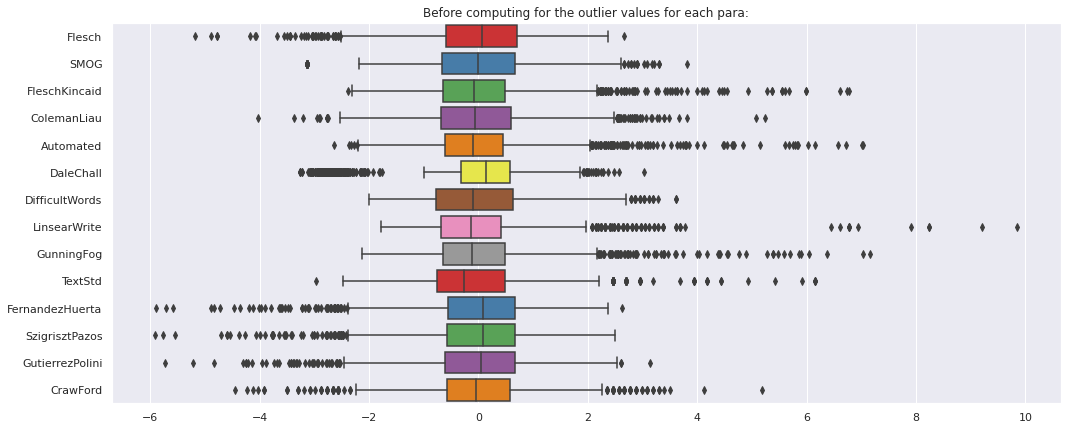

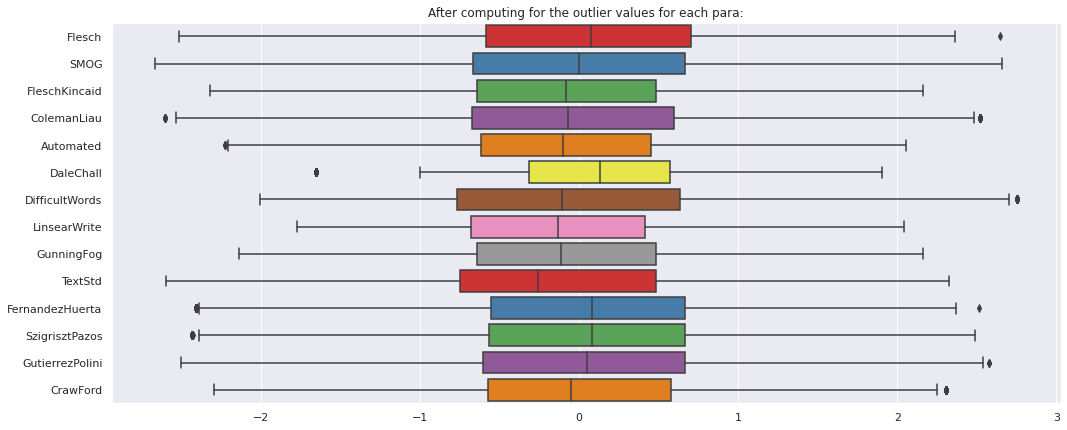


Training: Calculated corelation values:  {'Flesch': 0.5262048594252415, 'SMOG': -0.5373094230713599, 'FleschKincaid': -0.47772873377244995, 'ColemanLiau': -0.48546307894217605, 'Automated': -0.45101924448878933, 'DaleChall': -0.5886212405115571, 'DifficultWords': -0.5813696516188551, 'LinsearWrite': -0.4071911059881668, 'GunningFog': -0.48391256972808055, 'TextStd': -0.4781475768247509, 'FernandezHuerta': 0.5196105688499177, 'SzigrisztPazos': 0.5311655930134503, 'GutierrezPolini': 0.508497476019681, 'CrawFord': -0.555058325278465}

PosMean:
MSE:  1.7082734553344903    RMSE:  1.30701

NegMean:
MSE:  1.594335547913323    RMSE:  1.26267


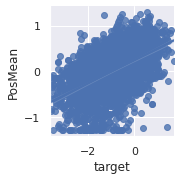

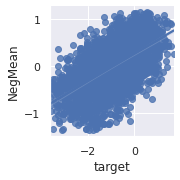

In [6]:
pdFeatures = return_all_index_framework(pdInputTrainData, 'training')

<a id='EDA'></a>
# 2. EDA
1. Find corlation between derived parameters and target if present any.

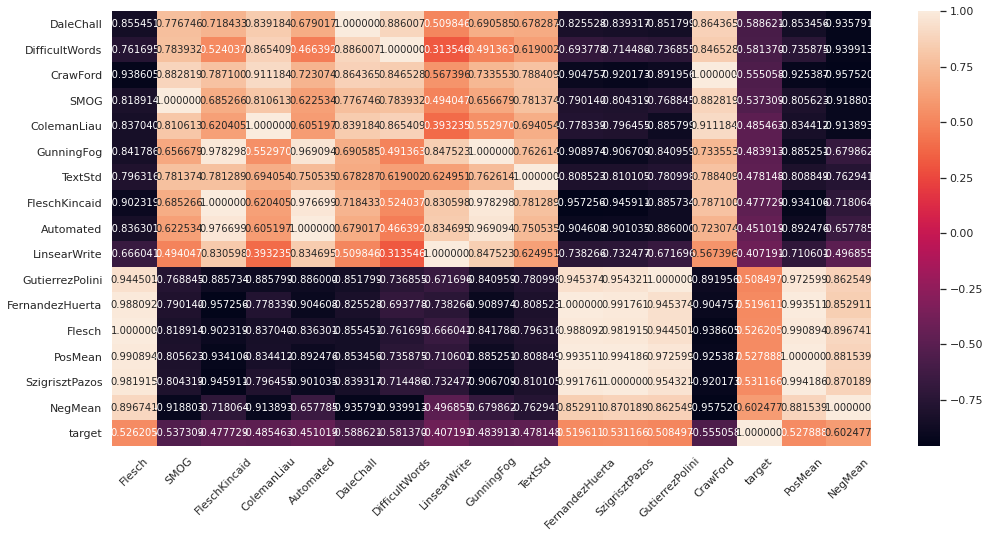

In [7]:
plt.figure( figsize=(17,8) )
sns.heatmap( pdFeatures.corr(method ='pearson').sort_values('target'), annot=True, fmt="f" )
plt.xticks( rotation=45 )
plt.show()

In [8]:
lstInputFeatures=['Flesch', 'SMOG', 'FleschKincaid', 'ColemanLiau', 'Automated', 'DaleChall', 'DifficultWords', 'LinsearWrite',
       'GunningFog', 'TextStd', 'FernandezHuerta', 'SzigrisztPazos',
       'GutierrezPolini', 'CrawFord', 'PosMean', 'NegMean']
pdFeatures = pdFeatures[lstInputFeatures + ['target']]

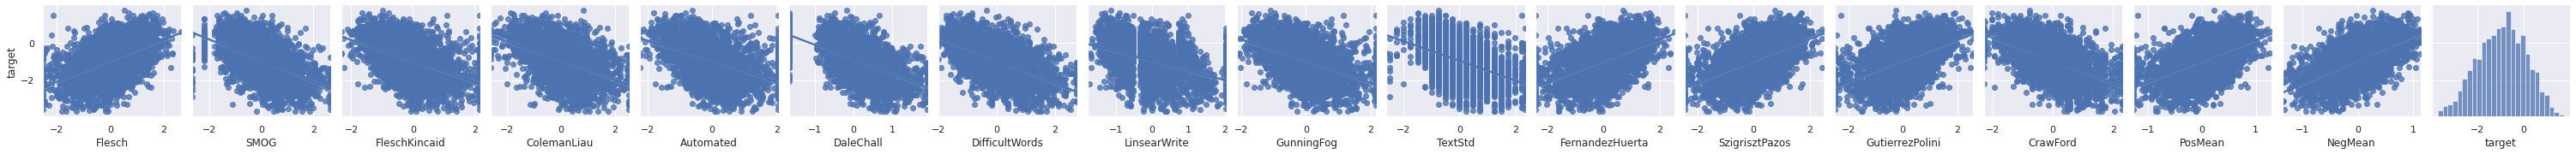

In [9]:
sns.pairplot(data=pdFeatures, y_vars='target', kind='reg')

<AxesSubplot:>

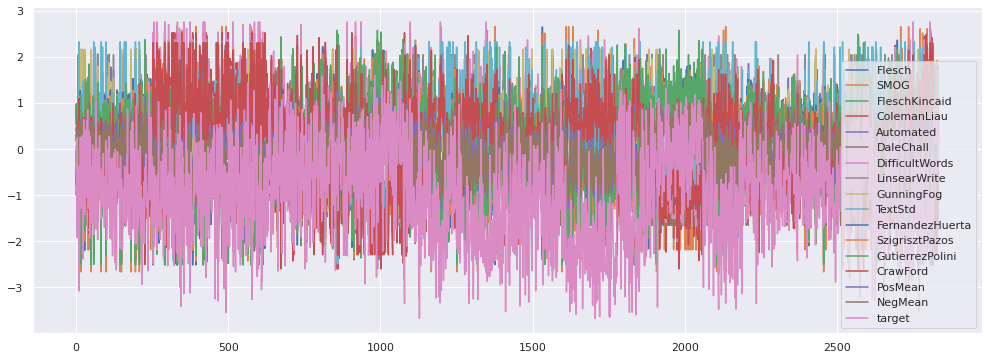

In [10]:
pdFeatures.plot(figsize=(17, 6))

<AxesSubplot:>

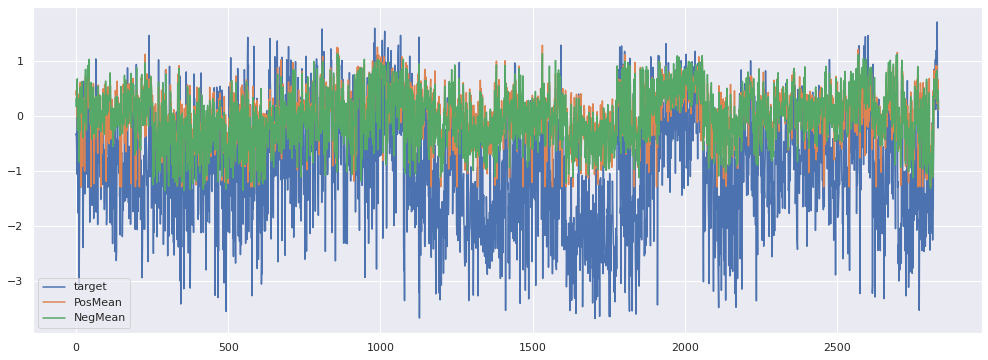

In [11]:
pdFeatures[['target', 'PosMean', 'NegMean']].plot(figsize=(17, 6))

<a id='ModelDevelopment'></a>
# 3. Multi Linear Model training-testing to finalise the model(s)

In [12]:
def linear_models(X_train, y_train, X_test, y_test):
    
    lstClassifiers = [
                        svm.SVR(kernel='poly', degree=2, max_iter=-1), # SVR: Epsilon-Support Vector Regression.
                        linear_model.SGDRegressor(penalty='l1', learning_rate='adaptive'),
                        linear_model.BayesianRidge(),
                        #linear_model.LassoLars(),
                        linear_model.ARDRegression(),
                        linear_model.PassiveAggressiveRegressor(),
                        linear_model.TheilSenRegressor(),
                        linear_model.LinearRegression()
    ]
    
    pdModelsOp=DataFrame()      
    
    # Train models
    for clf in lstClassifiers:
        clf.fit(X_train.values, y_train.values)
        
        strModelName=str(clf)
        
        pdModelsOp[strModelName]=clf.predict(X_test)
        print(strModelName)
        calculate_rmse( y_test, pdModelsOp[strModelName] )
        
        
    pdModelsOp['Actual'] = y_test.values
    
    pdModelsOp=pdModelsOp.rename(columns={\
                """SVR(degree=2, kernel='poly')""":'SVR',\
                """SGDRegressor(learning_rate='adaptive', penalty='l1')""":'SGDR',\
                'BayesianRidge()':'BR',
                'ARDRegression()':'ARDR', 
                'PassiveAggressiveRegressor()':'PAR',\
                'TheilSenRegressor(max_subpopulation=10000)':'TSR',  \
                'LinearRegression()':'LR',
                #'LassoLars()':'LL', 
                'Actual':'target'})
    
    return pdModelsOp

#### OBSERVATION:
- After rying out different combinations of parameters and cmparing their RMSE finalised parameters to use. 

SVR(degree=2, kernel='poly')
MSE:  0.8657154495591789    RMSE:  0.93044
SGDRegressor(learning_rate='adaptive', penalty='l1')
MSE:  0.6157094296762478    RMSE:  0.78467
BayesianRidge()
MSE:  0.616313661785206    RMSE:  0.78506
ARDRegression()
MSE:  0.6165747693879904    RMSE:  0.78522
PassiveAggressiveRegressor()
MSE:  1.115197641838423    RMSE:  1.05603
TheilSenRegressor(max_subpopulation=10000)
MSE:  0.6532705035948069    RMSE:  0.80825
LinearRegression()
MSE:  0.6193500731066057    RMSE:  0.78699


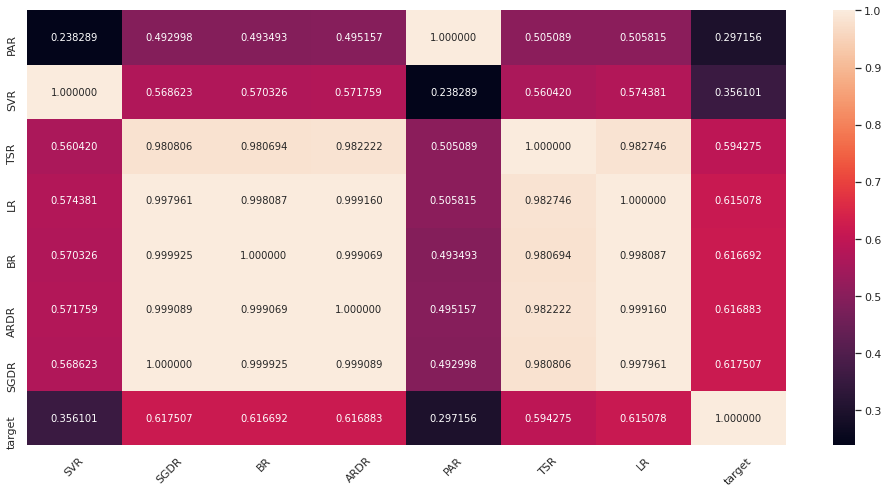

In [13]:
X, Y = pdFeatures[lstInputFeatures], pdFeatures['target']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=333)
pdModelsOp=linear_models(X_train, y_train, X_test, y_test)
plt.figure( figsize=(17,8) )
sns.heatmap( pdModelsOp.corr(method ='pearson').sort_values('target'), annot=True, fmt="f" )
plt.xticks( rotation=45 )
plt.show()

<AxesSubplot:>

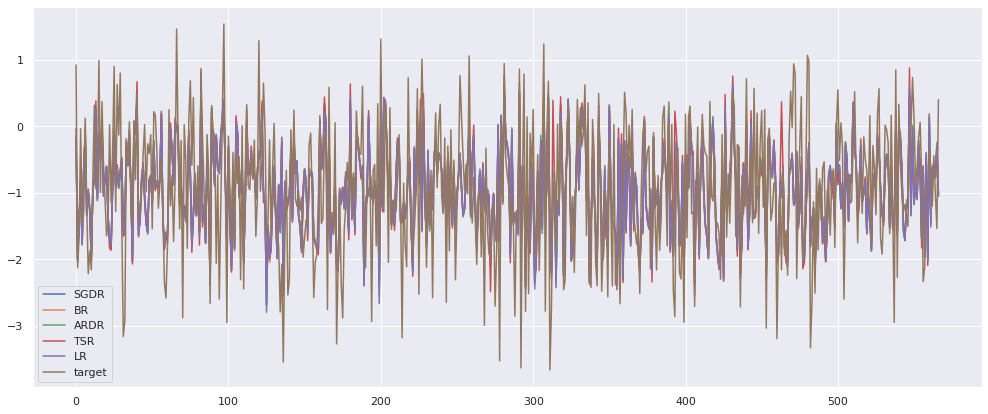

In [14]:
pdModelsOp[['SGDR', 'BR', 'ARDR', 'TSR', 'LR', 'target']].plot(figsize=(17,7))

#### OBSERVATION: Model selected 
- After comparing performance of all the linear models I am selecting SGDRegressor is selected for the final prediction

In [15]:
# Train SVR model on training data for the prediction on test data
SGDRegressor=linear_model.SGDRegressor(penalty='l1', learning_rate='adaptive')
X, Y = pdFeatures[lstInputFeatures], pdFeatures['target']
SGDRegressor.fit(X.values, Y.values)

SGDRegressor(learning_rate='adaptive', penalty='l1')

<a id='SubmitFinalOutput'></a>
# 4. Submit Final Output
1. Preparing Test data to predict possible readability value 

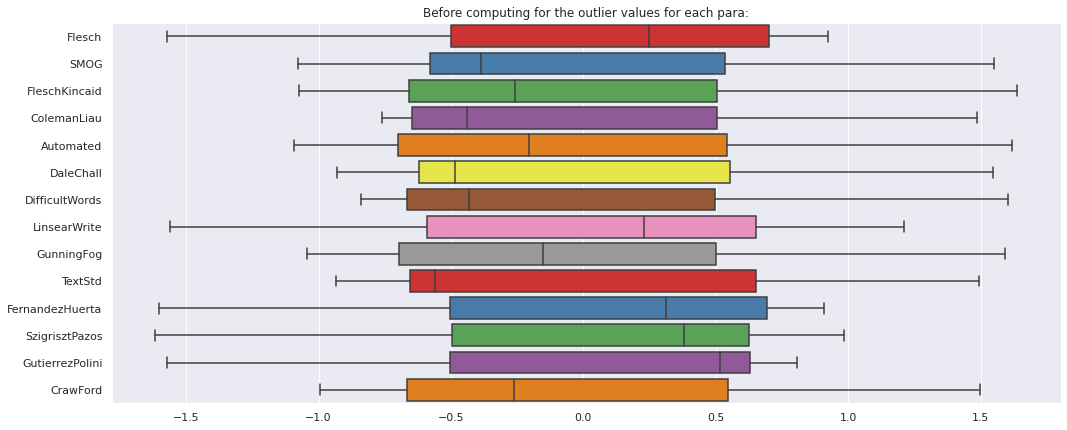

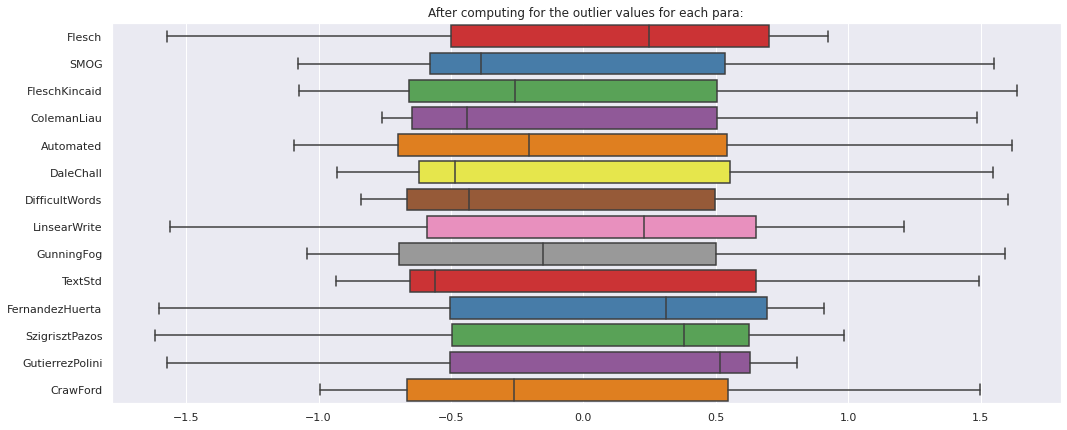

CPU times: user 802 ms, sys: 16.2 ms, total: 818 ms
Wall time: 811 ms


In [16]:
pdTest=read_csv("/kaggle/input/commonlitreadabilityprize/test.csv")
pdSample=read_csv('/kaggle/input/commonlitreadabilityprize/sample_submission.csv')
%time pdTest=return_all_index_framework(pdTest, 'testing')

In [17]:
y_pred = SGDRegressor.predict(pdTest)
pdSample['target']=np.round(y_pred, 6)
pdSample

,id,target
0,c0f722661,-0.609689
1,f0953f0a5,-0.107367
...,...,...
5,12537fe78,-0.520486
6,965e592c0,-0.157233


In [18]:
pdSample.to_csv("submission.csv",index = False)

<a id='SubmitFinalOutput'></a>
# 5. Save Final Model

In [19]:
# To save and reuse the model use following code        
def save_model(model, strModelName):
    import pickle
    # save the model to disk
    #filename = 'finalized_model.sav'
    filename = strModelName + '.sav'
    pickle.dump(model, open(filename, 'wb'))
    
    return 

#save_model(clf, strModelName)

def load_model(strModelName):
    
    filename = strModelName + '.sav'
    # load the model from disk
    loaded_model = pickle.load(open(filename, 'rb'))
    
    return loaded_model



#loaded_model = load_model(strModelName)
#result = loaded_model.score(X_test, y_test)
#print(result)